# Explore MNIST w/ ANN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
# MNIST IMAGE FILES --> Tensors

In [109]:
transform = transforms.ToTensor()

In [110]:
train_data = datasets.MNIST(root='../Data',train=True,download=True,transform=transform)

In [111]:
test_data = datasets.MNIST(root='../Data',train=False,download=True,transform=transform)

In [112]:
image,label = train_data[0]

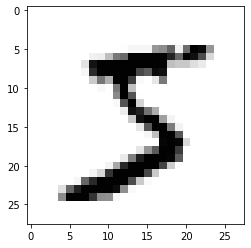

In [113]:
plt.imshow(image.reshape((28,28)),cmap='Greys')

In [114]:
# How to load in batches with dataloader? batches: subsets; e.g. 100 images at a time fed into network
torch.manual_seed(101)  # random shuffle of data

train_loader = DataLoader(train_data,batch_size=100,shuffle=True)  # shuffle in case its ordered for labels

test_loader = DataLoader(test_data,batch_size=500,shuffle=False)  # Can be larger set...

In [115]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [116]:
# First batch
for images,labels in train_loader:
    break
    # loop would go through 600 times (60000/100)
    # neat trick to get the first batch

In [117]:
images.shape  # number of images, colorchannel, width, height

torch.Size([100, 1, 28, 28])

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


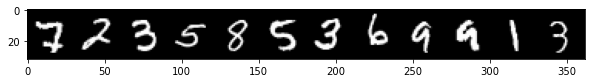

In [118]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC (Width, Heigth, Colorchannel)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [119]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self,in_sz=784,out_sz=10,layers=[120,84]):  #flatten=28x28=784
        
        super().__init__()  #to instantiate nn.Module
        
        self.fc1 = nn.Linear(in_sz,layers[0])  # fc -> fully connected layer
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
        
    def forward(self, X):
        
        X = F.relu(self.fc1(X))  # Activation function
        X = F.relu(self.fc2(X))
        X = self.fc3(X)  # dont use F.relu at last, classification prolem -> technically passing it through different act. fct. -> log_softmax
        
        return F.log_softmax(X,dim=1)
        

In [165]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [166]:
# ANN --> CNN (more efficient and less parameters)
for param in model.parameters():
    print(param.numel())  # number of elements in all parameters

94080
120
10080
84
840
10


Connections, number of neurons, connections, number of neurons, ...  -> 105214 total parameters

In [167]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [168]:
images.shape  # --> Flatten: [100,784], color channel doesn't matter

torch.Size([500, 1, 28, 28])

In [169]:
images.view(100, -1)  # first dimension (100) stays the same

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [171]:
import time
start_time = time.time()

# Training

epochs = 10

# TRACKERS, not neccessary but nice
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0  # keeping track how many we get correct in both sets
    tst_corr = 0
    
    for b, (X_train,y_train) in enumerate(train_loader):  #train_loader gives image and label
        
        b+=1  # starts at batch 0 so we start at batch 1
        
        # Last Layer -> 10 Nerons
        # [0.1,0.0,...,0.8] probabilities
        y_pred = model(X_train.view(100,-1))  # flatten image here
        loss = criterion(y_pred,y_train)
        
        # some statistics
        predicted = torch.max(y_pred.data,1)[1]  # index of most probable label
        batch_corr = (predicted == y_train).sum()  # how many matches where predicted equals correct label
        trn_corr += batch_corr
        
        # Update parameters, BACKPROP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f'Epoch {i} batch:{b} loss:{loss.item()} accuracy:{acc}')
            
    train_losses.append(loss.detach().numpy())  # saving loss only for last batch
    train_correct.append(trn_corr)
    
    
    
    # ALSO TEST THE MODEL DURING EACH EPOCH
    
    with torch.no_grad():
        
        for b, (X_test,y_test) in enumerate(test_loader):
            
            y_val = model(X_test.view(500,-1))
            
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()
            
    
    loss = criterion(y_val,y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)


total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

Epoch 0 batch:200 loss:0.2995501160621643 accuracy:82.655
Epoch 0 batch:400 loss:0.2725899815559387 accuracy:87.2475
Epoch 0 batch:600 loss:0.18161915242671967 accuracy:89.31666666666666
Epoch 1 batch:200 loss:0.17173445224761963 accuracy:94.625
Epoch 1 batch:400 loss:0.05133364349603653 accuracy:95.005
Epoch 1 batch:600 loss:0.14173491299152374 accuracy:95.25166666666667
Epoch 2 batch:200 loss:0.1681029200553894 accuracy:96.565
Epoch 2 batch:400 loss:0.17132745683193207 accuracy:96.53
Epoch 2 batch:600 loss:0.10914479941129684 accuracy:96.59166666666667
Epoch 3 batch:200 loss:0.14204615354537964 accuracy:97.47
Epoch 3 batch:400 loss:0.012089843861758709 accuracy:97.4875
Epoch 3 batch:600 loss:0.07614830136299133 accuracy:97.40833333333333
Epoch 4 batch:200 loss:0.050012458115816116 accuracy:98.02
Epoch 4 batch:400 loss:0.10280344635248184 accuracy:97.955
Epoch 4 batch:600 loss:0.09675315767526627 accuracy:97.97
Epoch 5 batch:200 loss:0.07435257732868195 accuracy:98.495
Epoch 5 batch:4

Training data: 60000 images -> 600 batches

Test data: 10000 images -> 20 batches

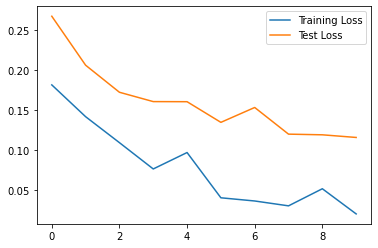

In [172]:
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Test Loss')
plt.legend()

# plotting losses only for last batch

In [173]:
train_acc = [t/600 for t in train_correct]
test_acc = [t/100 for t in test_correct]

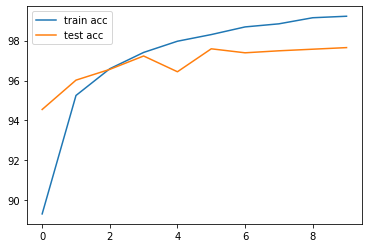

In [175]:
plt.plot(train_acc,label='train acc')
plt.plot(test_acc,label='test acc')
plt.legend()

In [176]:
# NEW UNSEEN DATA

test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [177]:
with torch.no_grad():
    correct = 0
    
    for X_test,y_test in test_load_all:
        y_val = model(X_test.view(len(X_test),-1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted==y_test).sum()

In [181]:
correct.item()/len(test_data)*100

97.65

In [182]:
confusion_matrix(predicted.view(-1),y_test.view(-1))  # diagonals: how many it gets right per class

array([[ 971,    0,    1,    1,    0,    1,    1,    1,    3,    5],
       [   0, 1122,    2,    0,    1,    1,    3,    8,    0,    3],
       [   2,    3, 1017,    6,    6,    0,    2,   12,    2,    0],
       [   1,    3,    3,  993,    0,   19,    1,    5,    3,    9],
       [   0,    0,    1,    0,  950,    1,    2,    0,    0,    7],
       [   0,    0,    0,    1,    0,  850,    1,    1,    2,    8],
       [   3,    1,    2,    1,    9,    9,  947,    0,    3,    1],
       [   0,    0,    3,    3,    2,    0,    0,  990,    2,    0],
       [   3,    6,    2,    3,    2,   10,    1,    6,  956,    7],
       [   0,    0,    1,    2,   12,    1,    0,    5,    3,  969]],
      dtype=int64)